# Trader Performance vs Market Sentiment Analysis

## Objective

This analysis investigates how Bitcoin market sentiment (Fear vs Greed) influences trader behavior and performance on Hyperliquid.

The goals are:
- Compare trader profitability under different sentiment regimes
- Examine behavioral shifts in trade frequency and direction
- Identify actionable strategy insights
- Evaluate volatility and risk characteristics


IMPORT LIBRARIES

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


LOAD DATASETS

In [53]:
sentiment=pd.read_csv("fear_greed_index.csv")

trader=pd.read_csv("historical_data.csv",low_memory=False)
print("Sentiment shape:",sentiment.shape)
print("Trader shape:",trader.shape)


Sentiment shape: (2644, 4)
Trader shape: (211224, 16)


## Data Cleaning – Sentiment

- Converted date to datetime format
- Consolidated sentiment categories into Fear and Greed
- Removed Neutral observations for clear comparison


CLEAN SENTIMENT

In [54]:
sentiment['date']=pd.to_datetime(sentiment['date'])

sentiment['sentiment_group']=sentiment['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})
sentiment=sentiment[sentiment['sentiment_group'].isin(['Fear','Greed'])]
print(sentiment['sentiment_group'].value_counts())


sentiment_group
Fear     1289
Greed     959
Name: count, dtype: int64


## Data Cleaning – Trader Dataset

- Converted timestamps using dayfirst=True
- Created daily date column
- Aggregated trades at daily level


CONVERT TIMESTAMP

In [55]:
trader['Timestamp IST']=pd.to_datetime(
    trader['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)
trader['date']=trader['Timestamp IST'].dt.date
trader['date']=pd.to_datetime(trader['date'])
print("Null timestamps:",trader['Timestamp IST'].isnull().sum())


Null timestamps: 0


FEATURE ENGINEERING

In [56]:
# Daily PnL
daily_pnl=trader.groupby('date')['Closed PnL'].sum().reset_index()
# Daily trade count
daily_trades=trader.groupby('date').size().reset_index(name='trade_count')
# Long/Short split
daily_side=trader.groupby(['date','Side']).size().unstack(fill_value=0).reset_index()
# Merge metrics
daily_metrics=daily_pnl.merge(daily_trades, on='date')
daily_metrics=daily_metrics.merge(daily_side, on='date')
daily_metrics['long_short_ratio'] = daily_metrics['BUY'] / daily_metrics['SELL'].replace(0,1)
daily_metrics.head()


,date,Closed PnL,trade_count,BUY,SELL,long_short_ratio
0,2023-05-01,0.000000,3,3,0,3.000000
1,2023-12-05,0.000000,9,7,2,3.500000
2,2023-12-14,-205.434737,11,5,6,0.833333
3,2023-12-15,-24.632034,2,2,0,2.000000
4,2023-12-16,0.000000,3,3,0,3.000000


MERGE SENTIMENT

In [57]:
final_data=daily_metrics.merge(
    sentiment[['date','sentiment_group']],
    on='date',
    how='inner'
)
print("Final shape:",final_data.shape)
final_data.head()


Final shape: (412, 7)


,date,Closed PnL,trade_count,BUY,SELL,long_short_ratio,sentiment_group
0,2023-05-01,0.000000,3,3,0,3.000000,Greed
1,2023-12-05,0.000000,9,7,2,3.500000,Greed
2,2023-12-14,-205.434737,11,5,6,0.833333,Greed
3,2023-12-15,-24.632034,2,2,0,2.000000,Greed
4,2023-12-16,0.000000,3,3,0,3.000000,Greed


## Fear vs Greed Performance Comparison

We compare:
- Average Daily PnL
- Trade Count
- Long/Short Bias


AGGREGATE COMPARISON

In [58]:
comparison=final_data.groupby('sentiment_group').agg({
    'Closed PnL':'mean',
    'trade_count':'mean',
    'long_short_ratio':'mean'
}).reset_index()
comparison


,sentiment_group,Closed PnL,trade_count,long_short_ratio
0,Fear,39012.054192,792.733333,3.778644
1,Greed,15847.884637,294.120521,2.779529


VISUALIZATION

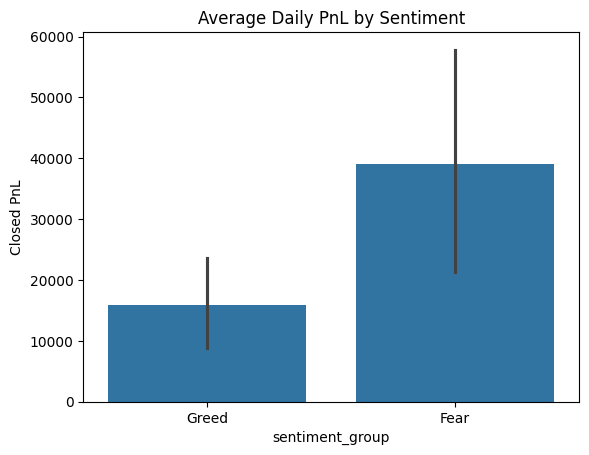

In [59]:
plt.figure()
sns.barplot(data=final_data,x='sentiment_group', y='Closed PnL')
plt.title("Average Daily PnL by Sentiment")
plt.show()


## Volatility Analysis

Standard deviation of PnL across sentiment regimes.

Higher dispersion indicates greater volatility and opportunity magnitude.


VOLATILITY CODE

In [60]:
volatility=final_data.groupby('sentiment_group')['Closed PnL'].std().reset_index()
volatility


,sentiment_group,Closed PnL
0,Fear,96894.941505
1,Greed,66645.098043


WIN RATE ANALYSIS

In [61]:
trader['is_win']=trader['Closed PnL']>0

daily_win=trader.groupby('date')['is_win'].mean().reset_index()

final_data=final_data.merge(daily_win,on='date')

final_data.groupby('sentiment_group')['is_win'].mean().reset_index()


,sentiment_group,is_win
0,Fear,0.328876
1,Greed,0.384793


ACTIVITY SEGMENTATION

In [62]:
final_data['high_activity']=final_data['trade_count']>final_data['trade_count'].median()

segment_analysis=final_data.groupby(
    ['sentiment_group','high_activity']
)['Closed PnL'].mean().reset_index()

segment_analysis


,sentiment_group,high_activity,Closed PnL
0,Fear,False,920.346956
1,Fear,True,67580.834618
2,Greed,False,1436.323009
3,Greed,True,31740.086159


## Key Insights

1. Fear periods generate significantly higher average profitability than Greed periods.
2. Fear periods exhibit higher volatility and trade activity.
3. Greed periods show higher win rates but lower profit magnitude.
4. High activity during Fear produces exceptional returns.
5. Low activity trading yields minimal profitability in both regimes.


## Strategy Recommendations

1. During Fear periods:
   - Increase active participation
   - Allow larger position sizing
   - Accept lower win rate but aim for higher reward-to-risk trades

2. During Greed periods:
   - Focus on systematic, consistent trades
   - Target smaller but frequent profits
   - Avoid excessive leverage

3. Avoid low-activity trading days, as profitability remains limited.


## Final Observations

Based on the analysis, it is clear that market sentiment plays an important role in influencing trader behavior and profitability.

Fear phases tend to create high-volatility environments where active traders can capture large profits, even though win rates are lower. On the other hand, Greed phases show more consistent win rates but comparatively lower overall profitability.

These findings suggest that adapting trading style based on prevailing sentiment conditions can improve performance and risk management.
